In [1]:
import pandas as pd

In [2]:
from tqdm import tqdm_notebook

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import plotly.graph_objects as go

In [5]:
import numpy as np

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

In [ ]:
from converter import base64_to_bech32
import requests

In [ ]:
from itertools import product

In [8]:
validators_df = pd.read_csv("euler_validators_full.csv", usecols=["block", "validators"])

In [9]:
validators_df[["block", "validators"]].to_csv("euler_validators_partial.csv")

In [10]:
validators_df = pd.read_csv("euler_validators_partial.csv")

In [11]:
validators_df["validators"] = validators_df["validators"].apply(lambda x: eval(x))

In [12]:
validators_df["validators"] = validators_df["validators"].apply(lambda x: set(x))

In [13]:
all_validators = set([v for v_list in validators_df["validators"].tolist() for v in v_list])

### Визуализация работы валидаторов

In [14]:
# Последний актуальный блок
MAX_BLOCK = validators_df["block"].max()
MAX_BLOCK

3665414

In [15]:
validators_df["rounded_block"] = validators_df["block"].round(-4)

In [16]:
validators_df["rounded_block"].nunique()

368

In [17]:
x = validators_df["rounded_block"].unique().tolist()

In [18]:
all_y = []
labels = []
validator_traces = {}
for validator in tqdm_notebook(all_validators):
    validators_df["validator_mask"] = validators_df["validators"].apply(lambda x: validator in x).astype(float)
    y = validators_df.groupby("rounded_block")["validator_mask"].sum().tolist()
    all_y.append(y)
    labels.append(validator)
    validator_traces[validator] = y

In [19]:
cmap = matplotlib.cm.get_cmap('jet')

In [20]:
validator_colors = {
    validator: "rgba({})".format(", ".join([str(int(color * 255)) for color in cmap(np.sum(trace) / MAX_BLOCK)]))
    for validator, trace in validator_traces.items()
}

In [21]:
fig = go.Figure()

for validator, y in validator_traces.items():
    fig.add_trace(go.Scatter(
        x=x, y=y,
        mode='lines',
        name=validator[0:5] + "...",
        line=dict(width=0.5, color=validator_colors[validator]),
        stackgroup='one',
        groupnorm='percent'
    ))

fig.update_layout(
    showlegend=True,
    xaxis_type='linear',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

fig.show()

### Расчет вознаграждения для каждого валидатора

In [81]:
# Количество токенов, участвующее в раздаче
AMOUNT_OF_TOKENS = 10000000

In [82]:
validators_df["total_validators"] = validators_df["validators"].apply(lambda x: len(x))

In [83]:
b_step_simple_range = np.linspace(0, 1, 10) * AMOUNT_OF_TOKENS

In [84]:
def linear(block, k, b):
    return k * block + b

In [85]:
validators_df["rounded_block"] = validators_df["block"].round(-5)

In [ ]:
all_rewards = {}

for b in tqdm_notebook(b_step_simple_range):
    validators_df["total_reward"] = validators_df["block"].apply(lambda x: linear(x, 1, b)) 
    validators_df["validator_reward"] = validators_df["total_reward"] / validators_df["total_validators"] / validators_df["total_reward"].sum()

    rewards = {}
    for validator in tqdm_notebook(all_validators):
        validator_reward = validators_df[validators_df["validators"].apply(lambda x: validator in x)].groupby("rounded_block")["validator_reward"].sum()
        rewards[validator] = (validator_reward * AMOUNT_OF_TOKENS).to_dict()
        
    all_rewards[b] = rewards

In [88]:
sorted_validators = sorted(all_validators, key=lambda x: sum(all_rewards[0][x].values()))

В массиве - сколько каждый из валидаторов набрал по всем диапазонам блоков (включая пропуски)

In [89]:
def show_rewards_by_block(all_rewards, margin=0):
    values = []
    for block_range in validators_df["rounded_block"].unique():
        values.append([])
        for validator in sorted_validators:
            values[-1].append(all_rewards[validator].get(block_range, 0))

    cmap = matplotlib.cm.get_cmap('Reds')
    ind = np.arange(len(all_validators))    
    width = 0.08
    blocks_number = validators_df["rounded_block"].nunique()
    
    bottom_values = np.zeros(len(values[0]))
    for index, values_row in enumerate(values):
        plt.barh(ind - margin * width, values_row, width, color=cmap(index / blocks_number), left=bottom_values)
        bottom_values += values_row

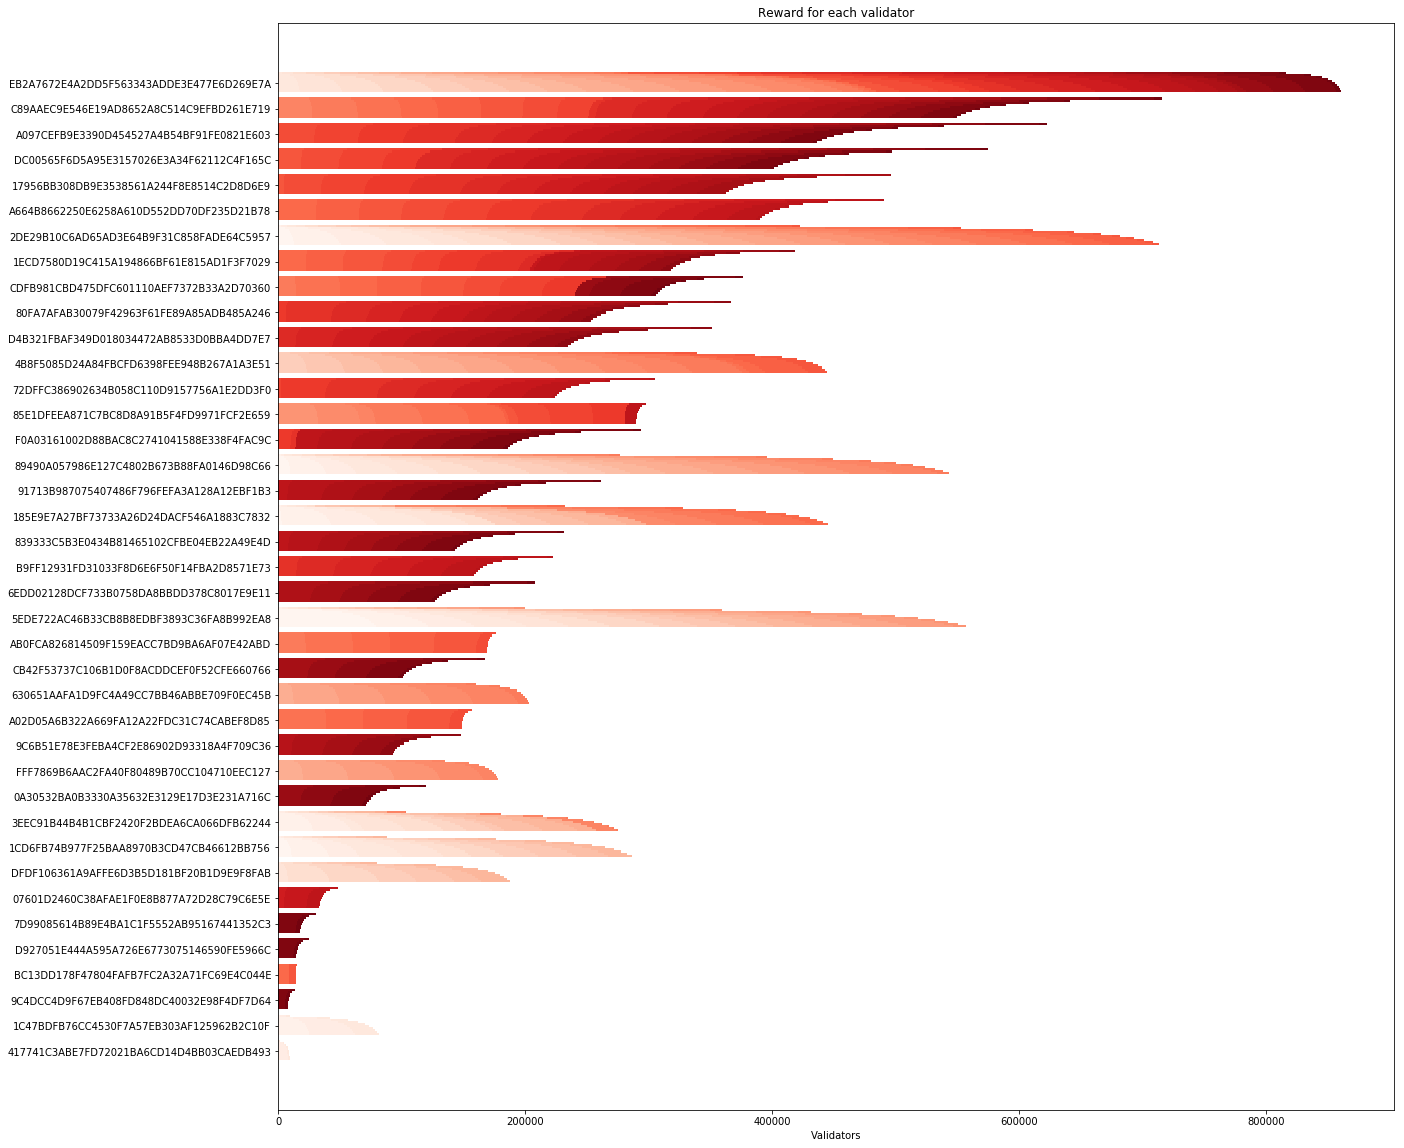

In [90]:
plt.figure(figsize=(20, 20))

for i, b in enumerate(b_step_simple_range):
    show_rewards_by_block(all_rewards[b], i)
    
plt.xlabel('Validators')
plt.title('Reward for each validator')
indices = np.arange(len(all_validators)) - 0.08 * 0.5 * len(b_step_simple_range)
plt.yticks(indices, sorted_validators)
plt.show()

Для каждого валидатора
- Более темным цветом показана часть вознаграждения, полученная за более поздние блоки
- Сверху вниз показано изменение вознаграждения при увеличении коэффициента $\frac{B}{K}$

### Вывод

При форме вознаграждения $reward = K*height+B$ и увеличении значения $\frac{B}{K}$
- новые валидаторы получают меньше;
- старые валидаторы получают больше.

На объем вознаграждения влияет только соотношение $\frac{B}{K}$, а не отдельно $B$ и $K$

# Визуализация балансов

In [91]:
K = 1
B = 0

In [92]:
validators_df["total_reward"] = validators_df["block"].apply(lambda x: linear(x, K, B)) 
validators_df["validator_reward"] = validators_df["total_reward"] / validators_df["total_validators"] / validators_df["total_reward"].sum()

selected_rewards = {}
for validator in tqdm_notebook(all_validators):
    validator_reward = validators_df["validator_reward"][validators_df["validators"].apply(lambda x: validator in x)].sum()
    selected_rewards[validator] = validator_reward

In [93]:
sorted_validators = sorted(all_validators, key=lambda x: selected_rewards[x])

In [94]:
data = [selected_rewards[v] for v in sorted_validators]

In [95]:
# Здесь можно указать имена валидаторов
validator_names = {
    sorted_validators[-1]: "That guy"
}

In [96]:
def get_name(i):
    validator_address = sorted_validators[i]
    main_name = validator_names.get(validator_address, validator_address[0:5] + "...")
    return main_name + " ({0:.2f}%)".format(selected_rewards[validator_address] * 100)

In [97]:
captions = [get_name(i) for i in range(len(sorted_validators))]

In [98]:
# Здесь можно указать, какое количество валидаторов в конце списка нужно объединить
OMITTED = 15
data = [sum(data[:OMITTED])] + data[OMITTED:]
captions = ["\n".join(captions[:OMITTED])] + captions[OMITTED:]

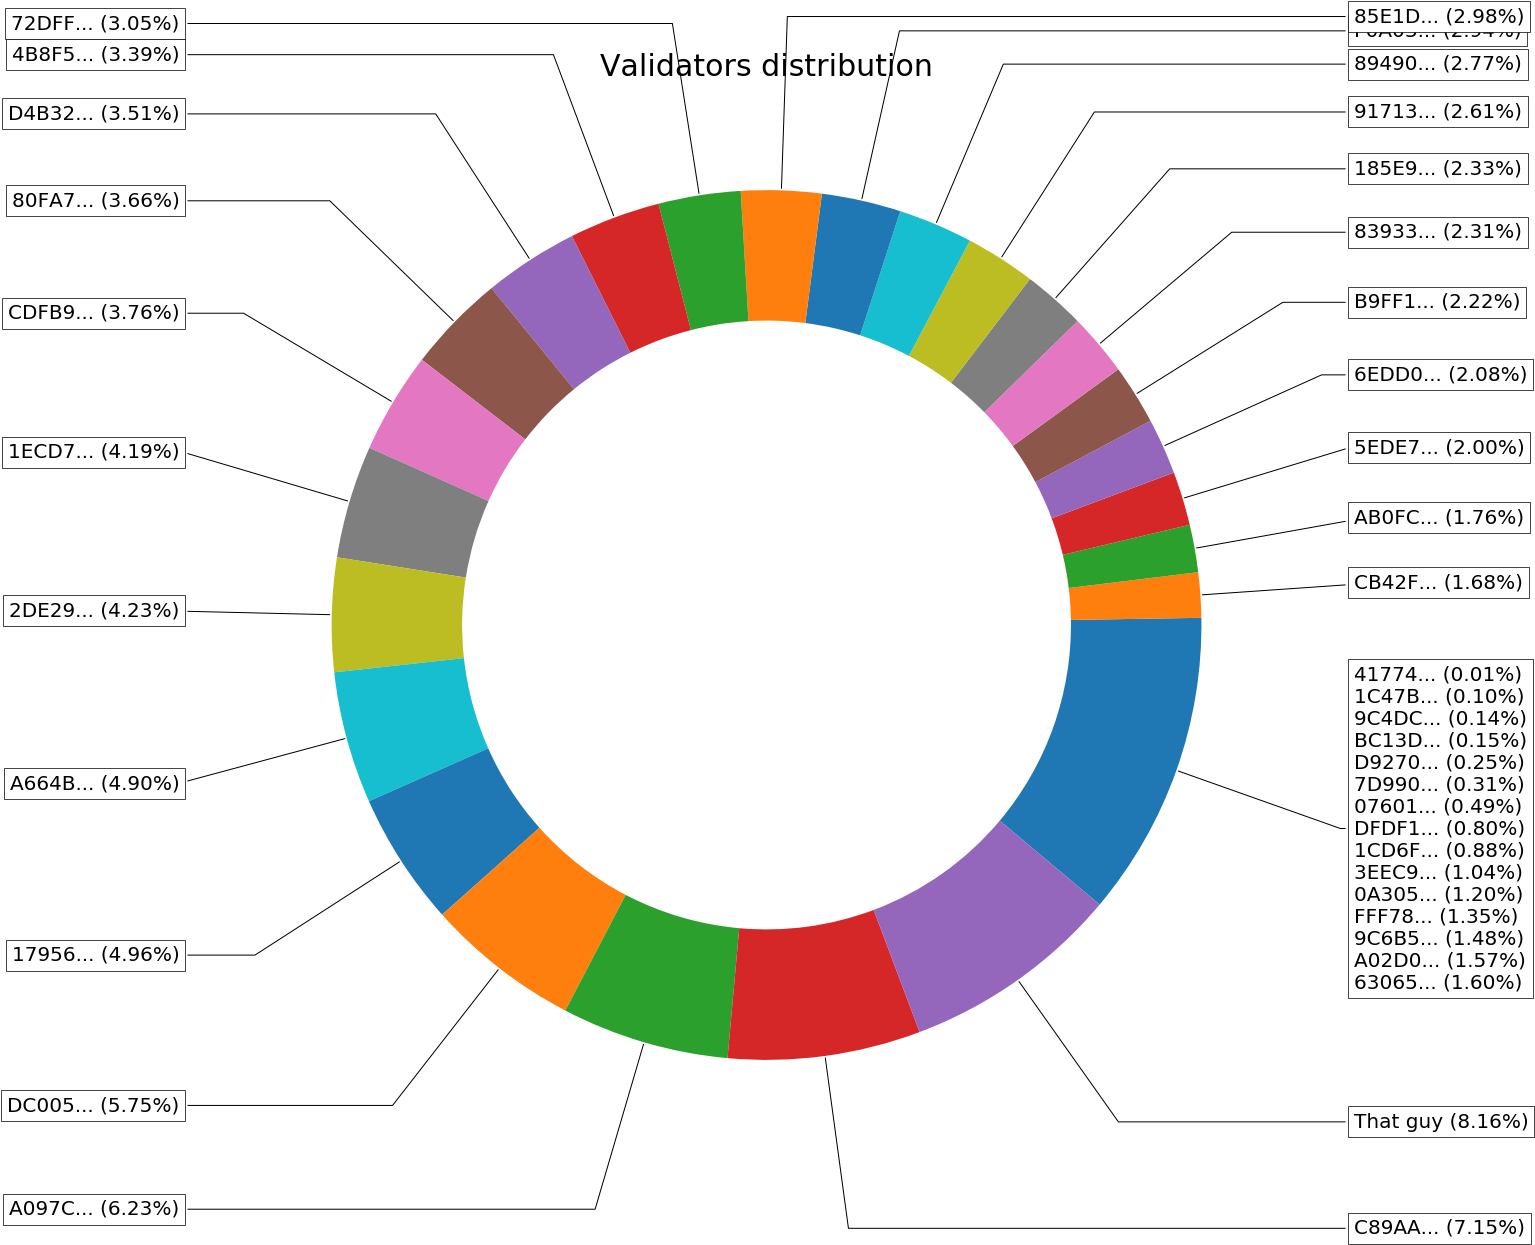

In [99]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.3), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(captions[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, fontsize=20, **kw)

ax.set_title("Validators distribution", fontsize=30)

plt.show()

### Составление таблицы с публичными ключами

In [101]:
# Additional converter check
assert base64_to_bech32("7GglL8LOiwNrYIiyGzsrEAaIvYn5iVqYLKG05TG5RXk=") == "cybervalconspub1zcjduepqa35z2t7ze69sx6mq3zepkwetzqrg30vflxy44xpv5x6w2vdeg4usdyhrzw"

cybervalconspub1zcjduepqa35z2t7ze69sx6mq3zepkwetzqrg30vflxy44xpv5x6w2vdeg4usdyhrzw


In [102]:
# Получить все base64 в соответствующем блоке (например, первом блоке для валидатора)
validators_base64 = {}

for validator in tqdm_notebook(all_validators):
    first_block = validators_df[validators_df["validators"].apply(lambda x: validator in x)]["block"].min()
    response = requests.get("http://86.57.254.202:36657/validators?height={}".format(first_block)).json()
    block_validators = response["result"]["validators"]
    pub_key = [v["pub_key"]["value"] for v in block_validators if v["address"] == validator][0]
    validators_base64[validator] = pub_key

In [ ]:
validators_bech32 = {k: base64_to_bech32(v) for k, v in validators_base64.items()}

In [104]:
balances_df = pd.Series({validators_bech32[k]: AMOUNT_OF_TOKENS * v for k, v in selected_rewards.items()})\
    .to_frame()\
    .reset_index()\
    .rename(columns={
        0: "balance",
        "index": "pub"
    })\
    .set_index("pub")

In [105]:
balances_df

balance
pub                                                              
cybervalconspub1zcjduepq02lxww0hz0numnjqllg83dr...  422555.015589
cybervalconspub1zcjduepq0324qpv7x27lu2wq7sysn3r...  495950.463052
cybervalconspub1zcjduepq09tzay8wyxsjeuh427gwv0j...  231367.561422
cybervalconspub1zcjduepq0w9yw5p0f59zm2p48zk5mfj...  715453.327464
cybervalconspub1zcjduepq2l7zur96a8tprvzff9slyxu...   48885.920607
cybervalconspub1zcjduepq324ahry4h6zh8w0zgkfsegu...  222434.551262
cybervalconspub1zcjduepq5arnm30ul793222qt8y3avn...  297907.395577
cybervalconspub1zcjduepq5e3957jklzz9ddxgldgf49u...  376081.430124
cybervalconspub1zcjduepq5mxque3sa4dmvvq0vcuy96t...  208061.596446
cybervalconspub1zcjduepq5q2404fvgx2czsttk4npm4c...  304995.447049
cybervalconspub1zcjduepq6cgzps6f8xy9c9f4zrn2zyd...  339039.657920
cybervalconspub1zcjduepq78jfyagh6hk4pzjk9zu8de7...  160320.498835
cybervalconspub1zcjduepq7mxh22ruwgp4thugxcswupa...   13654.135235
cybervalconspub1zcjduepqa35z2t7ze69sx6mq3zepkwe...  816403.338641
cybervalconspub1zcjduepqa8q0cjfyquusqjfeju0fkly...  418731.936473
cybervalconspub1zcjduepqapz5279xrwsje2cyt87ln6t...  293978.212742
cybervalconspub1zcjduepqcye93ds4tpmtyqec5e43f6s...  157230.975941
cybervalconspub1zcjduepqd6xljhc47gsrnlww02f0j29...  103740.938818
cybervalconspub1zcjduepqdpltg7zrf2qrnam0ypt7l3y...   15062.502347
cybervalconspub1zcjduepqer5hu0x9dlqcffv9mr3f5wm...  490385.523329
cybervalconspub1zcjduepqfsdnp6ldsd9f9ucddskvjqa...  277094.603610
cybervalconspub1zcjduepqfzwh9aqn8w24p0gv5z58r4g...  135281.335007
cybervalconspub1zcjduepqh04jd9p9yq5v69k0vk7juzf...   25135.662806
cybervalconspub1zcjduepqjzt4g5z9syccc9vnr0h8k6r...  232618.542067
cybervalconspub1zcjduepqkm7l89udqpjfk5lg2lagmda...  574502.257609
cybervalconspub1zcjduepqls9rnvdrr8kx66pt2pql4d0...  622534.997588
cybervalconspub1zcjduepqmhzqejncmz5zhlcnuyaue80...  261329.201345
cybervalconspub1zcjduepqmmj39chu8n8t5p944wcjmdm...   79936.824693
cybervalconspub1zcjduepqns8em8ktq9f39uaq732wlwh...   30541.182773
cybervalconspub1zcjduepqnwvmutug6tn4tmss7nau5u7...  199594.318826
cybervalconspub1zcjduepqq0ll0lt0cxpsw95cc5tsma4...  351343.178057
cybervalconspub1zcjduepqrsvwpw44m5ft0v8mehmm52u...    1321.424709
cybervalconspub1zcjduepqsggnm25k848qyjtftzl9daa...  148333.657211
cybervalconspub1zcjduepqsnmyssqtxjwkp402qjzt40q...  176339.360225
cybervalconspub1zcjduepqt24jnrckzjxzxqpkgh7sf0h...  167533.133248
cybervalconspub1zcjduepqvhk8edm633puw4q3kl54gj0...    9937.599620
cybervalconspub1zcjduepqxfmkwq6uv3rfsww4emlg9wr...   87992.998182
cybervalconspub1zcjduepqxq5pxk8vyp64v08w0uy0kcf...  120061.856362
cybervalconspub1zcjduepqxtw0cna5dqt2p2ylrylyn6y...  366327.437188